In [ ]:
from pycocotools.coco import COCO
annotation_file = "/home/yuvraj/YuvrajML/vjproject/annotations/instances_val2017.json"  

coco = COCO(annotation_file)

cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)

# Print category info
print(f"Total classes: {len(categories)}")
print("Classes:")
for cat in categories:
    print(f"- {cat['id']}: {cat['name']}")


In [3]:
!python /home/yuvraj/YuvrajML/vjproject/vj_project/data_preprocessing.py \
  --annotations /home/yuvraj/YuvrajML/vjproject/vj_project/annotations/instances_val2017.json \
  --images /home/yuvraj/YuvrajML/vjproject/vj_project/val2017 \
  --output /home/yuvraj/YuvrajML/vjproject/vj_project/data \
  --max-images 5000


loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Processing images:   0%|                     | 13/5000 [00:00<00:39, 127.32it/s]
[Warning] No annotations found for image: 000000226111.jpg
Processing images:   1%|                     | 26/5000 [00:00<00:39, 126.47it/s]
[Warning] No annotations found for image: 000000058636.jpg
Processing images:   3%|▋                   | 160/5000 [00:01<00:31, 154.40it/s]
[Warning] No annotations found for image: 000000458790.jpg
Processing images:   5%|█                   | 265/5000 [00:01<00:23, 200.09it/s]
[Warning] No annotations found for image: 000000461275.jpg
Processing images:   8%|█▌                  | 403/5000 [00:02<00:26, 170.31it/s]
[Warning] No annotations found for image: 000000268996.jpg
Processing images:   8%|█▋                  | 421/5000 [00:02<00:26, 172.03it/s]
[Warning] No annotations found for image: 000000370999.jpg
Processing images:  15%|██▉                 | 741/5000 [00:04<00:31, 135.17it

In [7]:
import os

folder = "/home/yuvraj/YuvrajML/vjproject/vj_project/data/images"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')

image_files = [f for f in os.listdir(folder) if f.lower().endswith(image_extensions)]
print(f"Number of images: {len(image_files)}")


Number of images: 4952


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = 'cuda'

In [ ]:
!python /home/yuvraj/YuvrajML/vjproject/vj_project/train.py \
  --data_path /home/yuvraj/YuvrajML/vjproject/vj_project/data \
  --epochs 5 \
  --lr 0.0001 \
  --num_classes 256 \
  --batch_size 8 \
  --weight_decay 0.01 \
  --img_size 512,512

In [ ]:
python /home/yuvraj/YuvrajML/vjproject/vj_project/train.py \
  --data_path /home/yuvraj/YuvrajML/vjproject/vj_project/data \
  --epochs 100 \
  --lr 0.0001 \
  --num_classes 80 \
  --batch_size 4 \
  --weight_decay 0.01 \
  --img_size 512,512


In [1]:
!mv /home/yuvraj/YuvrajML/vjproject/vj_project/data/val2017 /home/yuvraj/YuvrajML/vjproject/vj_project


In [28]:
import segmentation_models_pytorch as smp
from train import SegmentationModel 

config = {
    "num_classes": 256,
    "class_weights": [1.0] * 256,
    "lr": 1e-4,
    "weight_decay": 0.01,
    "img_size": (512, 512)
}

# Load the model
checkpoint_path = "/home/yuvraj/YuvrajML/checkpoints/epoch=26-step=8451.ckpt"  # update with your actual file
model = SegmentationModel.load_from_checkpoint(checkpoint_path, config=config)

In [29]:
model.eval()
model.cuda()  # if using GPU

SegmentationModel(
  (model): DeepLabV3Plus(
    (encoder): MixVisionTransformerEncoder(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (block1): Sequential(
        (0): Block(
          (norm1): LayerNorm((64,), eps

In [ ]:
import torch
print(f"Available GPUs: {torch.cuda.device_count()}")  # Should show 2
print(f"Current GPU: {torch.cuda.current_device()}")   # Should show 0

Available GPUs: 1
Current GPU: 0


: 

Unique values in prediction: [0]


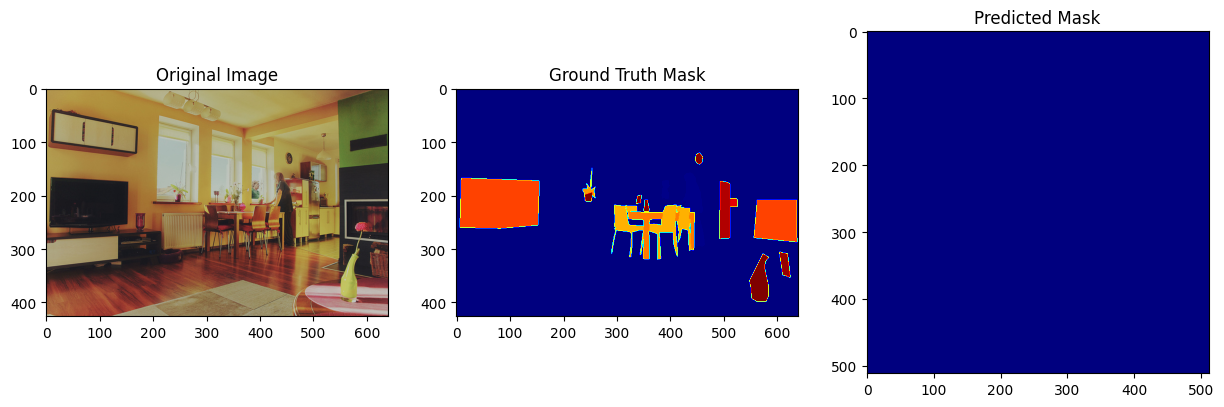

In [31]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Load image and mask
img_path = "/home/yuvraj/YuvrajML/vjproject/vj_project/data/val2017/000000000139.jpg"
mask_path = "/home/yuvraj/YuvrajML/vjproject/vj_project/data/masks/000000000139.png"

img = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError(f"Could not read image from {img_path}")
if mask is None:
    raise FileNotFoundError(f"Could not read mask from {mask_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize and normalize (same as training/validation)
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

transformed = transform(image=img)
input_tensor = transformed["image"].unsqueeze(0).cuda()

# Inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Check values
print("Unique values in prediction:", np.unique(prediction))

# Visualization
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="jet")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(prediction, cmap="jet")
plt.title("Predicted Mask")
plt.show()


In [25]:
from torchvision.transforms import ToTensor
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch

# Load an image
img = cv2.imread("/home/yuvraj/YuvrajML/vjproject/vj_project/data/val2017/000000001532.jpg")
mask = cv2.imread(str("/home/yuvraj/YuvrajML/vjproject/vj_project/data/masks/000000001532.png"), cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize and normalize (same as validation transform)
val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transformed = val_transform(image=img)
input_tensor = transformed["image"].unsqueeze(0).cuda()  # Add batch dimension

# Predict
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    print(prediction)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [27]:
import os
print(os.path.exists("/home/yuvraj/YuvrajML/vjproject/vj_project/data/val2017/0000000001490.jpg"))


False


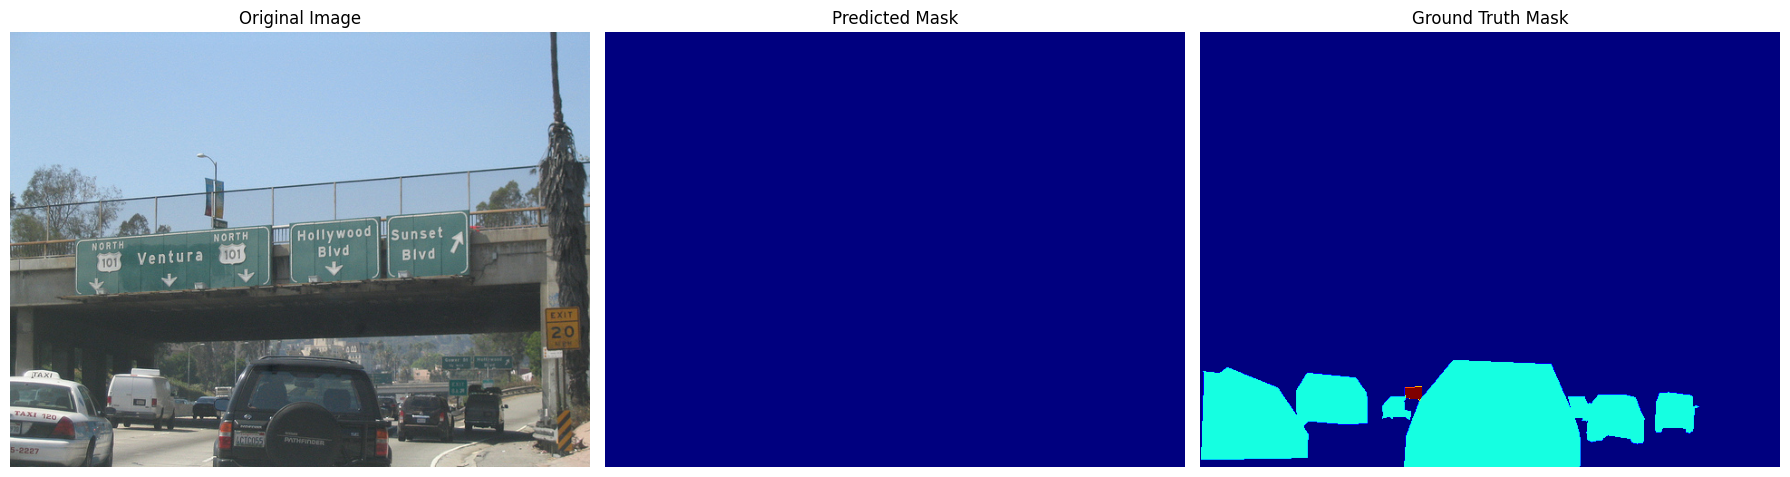

In [26]:
import matplotlib.pyplot as plt

# mask = cv2.imread(str("/home/yuvraj/YuvrajML/vjproject/vj_project/data/masks/000000000139.png"), cv2.IMREAD_GRAYSCALE)
prediction_resized = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# Visualization
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 2)
plt.imshow(prediction_resized, cmap='jet')
plt.title("Predicted Mask")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='jet')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


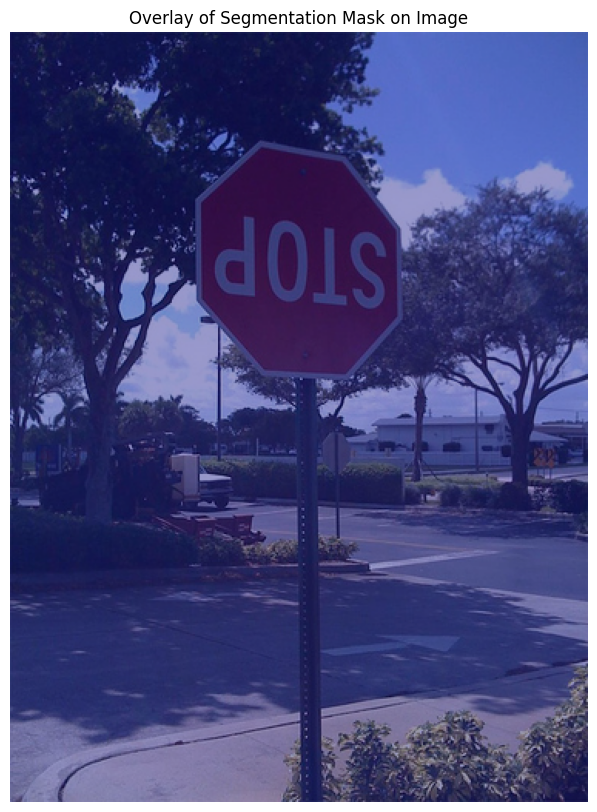

In [17]:
# Resize prediction to original image size (if needed)
mask_resized = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
import numpy as np
# Create overlay using colormap
overlay = cv2.applyColorMap((mask_resized * 10).astype(np.uint8), cv2.COLORMAP_JET)
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Blend original image and overlay
blended = cv2.addWeighted(img, 0.6, overlay, 0.4, 0)

# Display overlay
plt.figure(figsize=(10, 10))
plt.imshow(blended)
plt.title("Overlay of Segmentation Mask on Image")
plt.axis("off")
plt.show()
